# PW1 - Handwritten character recognition


In [1]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Ismael DEMBELE"    
assert your_name

In [6]:
!pip install os-sys

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      Traceback (most recent call last):
        File "/usr/loc

In [7]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [9]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [10]:
root_dir = './data/MNIST/'

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)


In [11]:
from torch.utils.data import DataLoader
BATCH_SIZE=256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [12]:
print(f"Nombre d'exemples dans le train : {len(train_dataset)}")
print(f"Nombre d'exemples dans le test  : {len(test_dataset)}")

Nombre d'exemples dans le train : 60000
Nombre d'exemples dans le test  : 10000


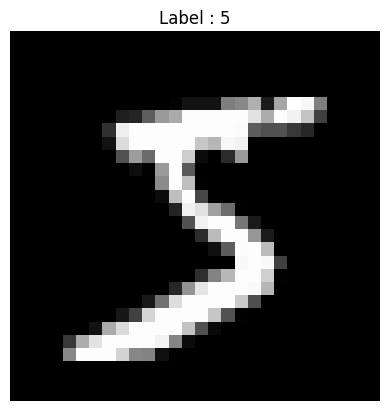

In [13]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label : {label}")
plt.axis('off')
plt.show()

In [14]:
print(f"Shape du tenseur image : {image.shape}")

Shape du tenseur image : torch.Size([1, 28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

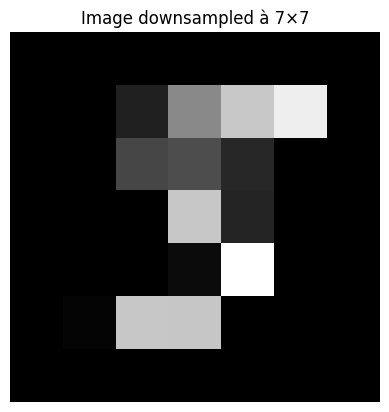

In [15]:
import torch.nn.functional as F

# Récupère une image
image, label = train_dataset[0]  # image: [1, 28, 28]

# Downsampling à 7x7
downsampled = F.interpolate(image.unsqueeze(0), size=(7, 7), mode='bilinear', align_corners=False)

# Affichage
plt.imshow(downsampled.squeeze(), cmap='gray')
plt.title("Image downsampled à 7×7")
plt.axis('off')
plt.show()

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # flatten en 784
])

In [17]:
train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

In [18]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        return self.linear(x)

In [19]:
LEARNING_RATE = 0.01

model = LinearModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [20]:
for epoch in range(NUM_EPOCH):
    model.train()
    total_loss = 0

    for batch in train_loader:
        x, y = batch
        x = x.view(x.size(0), -1)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")

[Epoch 1] Loss: 0.7088
[Epoch 2] Loss: 0.4211


In [21]:
#test accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.view(x.size(0), -1)
        y_pred = model(x)
        pred = y_pred.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

accuracy = correct / total * 100
print(f"Le Test accuracy est de {accuracy:.2f}%")


Le Test accuracy est de 89.86%


## A.2 - Loss and optimizer
Create a cross entropy loss.

In [22]:
def preprocess(x):
    x = F.avg_pool2d(x, kernel_size=4)  # [1, 7, 7]
    return x.view(-1)                   # [49]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    preprocess
])

In [23]:
train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(49, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
BATCH_SIZE=8
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(NUM_EPOCH):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.view(x.size(0), -1)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")


[Epoch 1] Loss: 2.0951


In [22]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x)
        pred = y_pred.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

accuracy = correct / total * 100
print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 74.08%


## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),  # [B, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2),                            # [B, 16, 14, 14]
            nn.Conv2d(16, 32, kernel_size=5, padding=2),# [B, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2),                            # [B, 32, 7, 7]
            nn.Flatten(),                               # [B, 32*7*7]
            nn.Linear(32*7*7, 10)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    total_correct = 0
    total_samples = 0

    for x, y in train_loader:
        if preprocess:
            x = preprocess(x)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1)
        total_correct += (pred == y).sum().item()
        total_samples += y.size(0)

    train_accuracy = total_correct / total_samples
    return optimizer, train_accuracy


def test(model, preprocess):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            if preprocess:
                x = preprocess(x)

            y_pred = model(x)
            pred = y_pred.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [ ]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_acc_list = []
test_acc_list = []

for epoch in range(1, NUM_EPOCH + 1):
    optimizer, train_accuracy = train(model, epoch, preprocess=None, optimizer=optimizer)
    test_accuracy = test(model, preprocess=None)

    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    print(f"[Epoch {epoch}] Train acc: {train_accuracy:.4f} | Test acc: {test_accuracy:.4f}")

In [23]:
# Jetter un coup d'oeil aux courbes
plt.plot(train_acc_list, label='Train acc')
plt.plot(test_acc_list, label='Test acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

NameError: name 'train_acc_list' is not defined

## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [ ]:
class MLP(nn.Module):
    def __init__(self, width, depth, input_dim=784, output_dim=10):
        super().__init__()

        layers = []

        # Entrée
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        # Couches intermédiaires
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        # Sortie
        layers.append(nn.Linear(width, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # [1, 28, 28] → [784]
])

In [ ]:
model = MLP(width=100, depth=3)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_acc_list = []
test_acc_list = []

for epoch in range(1, NUM_EPOCH + 1):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Test
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            correct_test += (y_pred.argmax(dim=1) == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test
    test_acc_list.append(test_acc)

    print(f"[Epoch {epoch}] Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # [B, 1, 28, 28] → [B, 8, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2)                             # [B, 8, 14, 14]
        )
        self.fc = nn.Linear(8 * 14 * 14, 10)            # Flatten + Linear

    def forward(self, x):
        x = self.conv(x)                                # [B, 8, 14, 14]
        x = x.view(x.size(0), -1)                       # [B, 1568]
        return self.fc(x)                               # [B, 10]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [ ]:
class DeepConvModel(nn.Module):
    def __init__(self, hidden_size=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # [B, 8, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2)                             # [B, 8, 14, 14]
        )

        self.classifier = nn.Sequential(
            nn.Linear(8 * 14 * 14, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)

transform = transforms.Compose([
    transforms.ToTensor()
])

model = DeepConvModel()

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

In [ ]:
import matplotlib.pyplot as plt

# Récupérer une image du test set
image, label = test_dataset[0]
image = image.unsqueeze(0)  # [1, 1, 28, 28]

# Passer l'image dans la couche convolutionnelle seule
model.eval()
with torch.no_grad():
    feature_maps = model.features(image)  # [1, 8, 14, 14]

# Afficher l'image d'origine
plt.figure(figsize=(2, 2))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Original image - label {label}")
plt.axis('off')
plt.show()

# Afficher les 8 feature maps
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_maps[0, i].cpu(), cmap='gray')
    plt.title(f"Feature map {i+1}")
    plt.axis('off')

plt.suptitle("Feature maps from Conv layer")
plt.tight_layout()
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.Linear(h, d)
        )

    def forward(self, x):
        return x + self.block(x)

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [ ]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()

        self.input_layer = nn.Linear(l, h)

        self.residual_blocks = nn.Sequential(*[
            ResidualBlock(h, h) for _ in range(k)
        ])

        self.output_layer = nn.Linear(h, out)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.residual_blocks(x)
        x = self.output_layer(x)
        return x

Exemple d’entraînement

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # [1, 28, 28] → [784]
])

train_dataset = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
model = ResidualModel(l=784, h=100, k=3, out=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCH = 5
train_acc_list = []
test_acc_list = []

for epoch in range(1, NUM_EPOCH + 1):
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (y_pred.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            correct_test += (y_pred.argmax(dim=1) == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test
    test_acc_list.append(test_acc)

    print(f"[Epoch {epoch}] Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Paramètres
n_batch = 4
n_classes = 10

# Entrée aléatoire : scores réels + labels entiers
s = torch.randn(n_batch, n_classes)            # Scores réels (non normalisés)
y = torch.randint(0, n_classes, [n_batch])     # Labels dans [0, 9]

# 1. CrossEntropyLoss = LogSoftmax + NLLLoss (automatique)
loss1 = nn.CrossEntropyLoss()(s, y)

# 2. LogSoftmax + NLLLoss manuels
log_softmax = nn.LogSoftmax(dim=1)(s)          # log(probabilités)
loss2 = nn.NLLLoss()(log_softmax, y)

# 3. Softmax puis log puis NLLLoss — ❌ en pratique incorrect !
softmax = nn.Softmax(dim=1)(s)
log = torch.log(softmax + 1e-9)                 # ajout epsilon pour éviter log(0)
loss3 = nn.NLLLoss()(log, y)

# Affichage des résultats
print(f"Loss 1 (CrossEntropyLoss)      : {loss1.item():.6f}")
print(f"Loss 2 (LogSoftmax + NLLLoss)  : {loss2.item():.6f}")
print(f"Loss 3 (Softmax + log + NLLLoss): {loss3.item():.6f}")

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [ ]:
def ce(logits, targets):
    # logits : [batch_size, num_classes]
    # targets : [batch_size] (entiers 0..C-1)

    # 1. softmax sur les classes
    softmax = F.softmax(logits, dim=1)  # [B, C]

    # 2. récupérer la proba associée à la bonne classe
    prob = softmax[torch.arange(len(targets)), targets]  # [B]

    # 3. log et moyenne (formule CE)
    loss = -torch.log(prob + 1e-9).mean()  # ajout epsilon pour stabilité

    return loss

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [ ]:
# Données extrêmes
n_batch = 4
n_classes = 10
logits = torch.randn(n_batch, n_classes) * 100  # grande variance
targets = torch.randint(0, n_classes, [n_batch])

# 1. CrossEntropyLoss (stable)
try:
    loss1 = nn.CrossEntropyLoss()(logits, targets)
    print(f"[1] CrossEntropyLoss: {loss1.item():.6f}")
except Exception as e:
    print(f"[1] CrossEntropyLoss failed: {e}")

# 2. LogSoftmax + NLLLoss (stable)
try:
    log_probs = F.log_softmax(logits, dim=1)
    loss2 = nn.NLLLoss()(log_probs, targets)
    print(f"[2] LogSoftmax + NLLLoss: {loss2.item():.6f}")
except Exception as e:
    print(f"[2] LogSoftmax + NLLLoss failed: {e}")

# 3. Softmax + log + NLLLoss (instable)
try:
    probs = F.softmax(logits, dim=1)
    log_probs_bad = torch.log(probs + 1e-9)
    loss3 = nn.NLLLoss()(log_probs_bad, targets)
    print(f"[3] Softmax + log + NLLLoss: {loss3.item():.6f}")
except Exception as e:
    print(f"[3] Softmax + log + NLLLoss failed: {e}")

Re-implement a stable version of cross-entropy.

In [ ]:
def stable_ce(logits, targets):
    # logits : [batch_size, num_classes]
    # targets : [batch_size]

    # Trick : soustraire le max par ligne pour stabiliser les exposants
    logits = logits - logits.max(dim=1, keepdim=True).values

    # Calcul stable du log-softmax
    log_sum_exp = torch.log(torch.sum(torch.exp(logits), dim=1))  # [batch]
    log_probs = logits[torch.arange(len(targets)), targets]       # [batch]

    # Cross-entropy
    loss = -log_probs + log_sum_exp
    return loss.mean()